<h2><center>Projeto de Inteligência Artificial</center></h2>
<h1><center>Genetic Algorithms</h1>

<h3></h3>


<h3><left> Realizado por Gonçalo Nogueira</center></h3>

<h4><left>Aluno nº 21603520</center></h4>



<h3><end>Orientação por Manuel Marques Pita</end></h3>

***

## Indice

### [Introdução](#BI)
### [Autómato Celular](#CA)
### [Algoritmo Genético](#GA)
### [Análise de Resultados](#Analysis)
### [Anexos](#Anexos)

***

<h2 id='BI'>Breve Introdução</h2>

<p>Neste relatório irei abordar a temática dos Algoritmos Genéticos e Computação Distribuída.</p>

In [18]:
import numpy as npy
import matplotlib.pyplot as plt
from matplotlib import colors
from random import randint
import random
import re
from collections import Counter
from collections import defaultdict
import operator
from matplotlib.backends.backend_pdf import PdfPages
import time
import threading
import csv
import seaborn as sns

***

# Autómato Celular<a id='CA'></a>

## Gerar Lattice

Função que recebe o tamanho desejado, bem como o k e gera uma lattice com 0 e 1 aleatórios.

In [19]:
def generate_lattice(ls, k):
    lattice = []
    for x in range(ls) :
        if(k==2):
            lattice.append(str(randint(0, 1)))
        else:
            lattice.append(str(randint(0, 2)))
    return lattice

## Gerar Condição

Função que recebe r, o phi e o k e gera uma regra em binário.

In [20]:
def condition_generator(r, phi, k):
    n = r * 2 + 1
    number_conditions = k**n
    if(k == 2):
        phi = bin(phi)[2:].zfill(number_conditions)
    else:
        phi = ternary(phi).zfill(number_conditions)
    phi = phi[::-1]
    return phi

## Update Lattice

Função que recebe uma lattice, o phi e o r e gera a lattice seguinte conforme o phi.

In [21]:
def update_lattice(lattice, phi, r) :
    NextL = []
    for x in range(len(lattice)) : #para cada elemento da lattice
        left = ""
        right = ""
        for y in range(r, 0, -1) :
            pos_left, pos_right = x - y, (x + (r - y) + 1) % len(lattice)            
            left += str(lattice[pos_left])
            right += str(lattice[pos_right])
        neighbourhood = int(left + str(lattice[x]) + right, 2)
        NextL.append(phi[neighbourhood])
    return(NextL)

## Run_CA

Função que recebe a lattice original, bem como o phi e o r. O que esta função irá fazer é correr em loop a função Update Lattice e assim gerar uma matriz espaço tempo. 

In [22]:
def run_ca(lattice, phi, r) :
    matrix = []
    matrix.append(lattice)
    new_lattice = []
    new_lattice = lattice
    for y in range(180):
        matrix.append(update_lattice(new_lattice, phi, r))
        new_lattice = matrix[-1]
    return matrix

## Plot and Save Cellular Automata

Função que recebe a matriz espaço/tempo e lhe dá o plot bem como guarda num ficheiro pdf.

In [23]:
def plot_and_save_ca(spacetime, k) :
    if(k == 2):
        img_color = colors.ListedColormap(['white', 'black'])
    else:
        img_color = colors.ListedColormap(['white', 'black', 'yellow'])
    
    plt.imshow(spacetime, interpolation='nearest', cmap=img_color)
    plt.colorbar()
    plt.show()


## Inputs e Main

Funções que geram inputs para o automato celular e correm o resto das funções.

In [24]:
def inputs():
    ls = 100 
    tm = 200
    k = 2 
    return ls, tm, k
def CA(phi, r):
    ls, tm, k = inputs()
    lattice = generate_lattice(ls, k)
    Y = []
    x = []    
    phi = condition_generator(r, phi, k)
    x = run_ca(lattice, phi, r)
    Y.append(x)
    mat_in_int = []
    m = len(Y)
    w = len(x[0])
    h = len(x)
    #print('X: ', x)
    mat_in_int = [[0]*w] * h 
    matrixes = [mat_in_int] * m
    i = 0
    
    for row in range(len(x)):    
        new_row = []
        for col in range(len(x[row])):           
            new_row.append(int(x[row][col]))
            continue       
        mat_in_int[row] = new_row    
    plot_and_save_ca(mat_in_int, k)
    

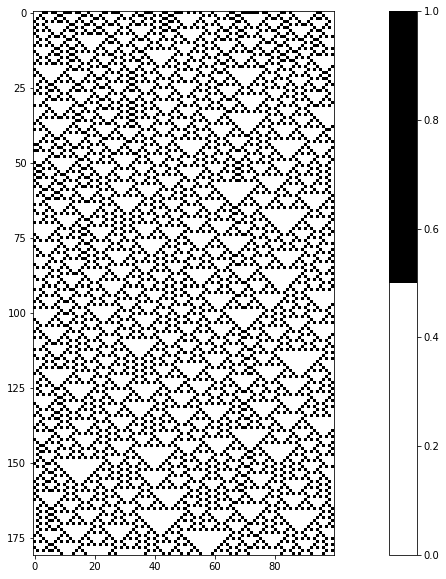

In [25]:
CA(18, 1)

***

# Algoritmo Genético<a id='GA'></a>

De seguida segue o código do Algoritmo Genético, que irá utilizar as funções acima do Automato Celular. Aqui, este Algoritmo vai correr 120 gerações de regras que irão utilizar o processamento do Automato para gerar matrizes espaço-tempo. Estas matrizes vão ser trabalhadas em código mais à frente.

In [26]:
maximum_rules = []
header = [['Generation', 'Rule', 'fitness']]

## Inicializar Pool

Esta função recebe k, o tamanho predifinido das lattice e o numero lattices. Vai gerar uma Lista de nt Lattices de tamanho LS. Esta função recorre à função Generate Lattice do Automato Celular.

In [27]:
def initialize_pool(k, ls, nt):
    T, Temp_T = [], []
    for x in range(nt):
        Temp_T = generate_lattice(ls, k)
        while Temp_T in T:
            Temp_T = generate_lattice(ls, k)
        T.append(Temp_T)
    return T

## Inicializar População

Esta função envia um numero entre 0 e k^k^n para a função condition_generator dentro de um loop. Isto vai gerar (neste caso) 50 regras completamente aleatórias. Atenção extra ao facto de que esta função envia um número decimal para a função condition_generator e esta vai converte-lo em binário.

In [28]:
def initialize_population(r, k, np):
    P = []
    n = k * 2 + 1
    number_possible_rules = k ** k ** n
    for x in range(np):
        rule = condition_generator(r, randint(0, number_possible_rules), k)
        if rule not in P:
            P.append(rule)    
    return P

## Score

Esta função é provavelmente a mais importante do Algoritmo Genético.
Aqui vai ser definido o critério de avaliação de qualidade das regras e eu segui a seguinte filosofia:

1. Validar o facto de o número de 1's e 0's ser igual na quarta linha a contar para o fim e na penúltima, bem como na antepenúltima e na última

2. Numa variável C, somar todas as ocorrencias do número que estiver em maioria na penúltima linha ao número de ocorrencias do outro número na ultima linha.

3. No caso de a primeira condição não se verificar, definir o score desta matriz como 0

4. Se a primeira condição se verificar, dividir C pelo tamanho total das duas ultimas duas linhas e retornar o valor.



In [29]:
def score_synchronization(matrix_espaco_tempo):
    fourthtolast_lattice, thirdtolast_lattice, secondtolast_lattice, last_lattice = matrix_espaco_tempo[-4], matrix_espaco_tempo[-3], matrix_espaco_tempo[-2], matrix_espaco_tempo[-1]
    one, zero = '1', '0'            
    ones = fourthtolast_lattice.count(one)
    zeros = len(fourthtolast_lattice) - ones
    if fourthtolast_lattice.count(one) == secondtolast_lattice.count(one) and thirdtolast_lattice.count(zero) == last_lattice.count(zero):
        if fourthtolast_lattice.count(one) > fourthtolast_lattice.count(zero):
            C = secondtolast_lattice.count(one) + last_lattice.count(zero)
        else:
            C = secondtolast_lattice.count(zero) + last_lattice.count(one)    
    else:
        return 0
    return float(C/(2*len(last_lattice)))

## Fitness

Aqui, vai ser chamada a função run_Ca do Automato Celular para uma regra e todas as lattices da pool. Depois, irá ser chamada função score_synchronization num loop que irá enviar todas as matrizes espaço/tempo retornadas pela função run_CA.
Irá guardar todos os scores numa lista e retornar a média dos mesmos.

In [30]:
def fitness_synchronization(phi, T, r):
    temp_score = 0
    scores = []
    average_score = 0
    for lattice in T:
        temp_matrix = run_ca(lattice, phi, r)
        temp_score = score_synchronization(temp_matrix)
        scores.append(temp_score)
    average_score = sum(scores)/len(T)
    print('phi: ', phi, 'fitness: ', average_score)
    return average_score

## Crossover

Na função Crossover, irá ocorrer a "reprodução" de regras por parte de dois pais. O estudo está a ser feito enviando 2 pontos de corte e depois estes são feitos em duas zonas aleatórias das regras. A função vai retornar, neste caso, 6 filhos misturados do adn dos pais.

In [31]:
def crossover(parent1, parent2, points):
    if(points == 1):
        pos = int(randint(2, len(parent1)-2))
        return parent1[:pos]+parent2[pos:], parent2[:pos]+parent1[pos:]
    elif(points == 2):        
        pos = int(randint(1, int(len(parent1)/2)))
        pos2 = int(randint(pos, len(parent1)))
        return parent1[:pos]+parent2[pos:pos2]+parent1[pos2:], parent2[:pos]+parent1[pos:pos2]+parent2[pos2:], parent1[:pos]+parent1[pos:pos2]+parent2[pos2:], parent1[:pos]+parent2[pos:pos2]+parent2[pos2:], parent2[:pos]+parent1[pos:pos2]+parent1[pos2:], parent2[:pos]+parent2[pos:pos2]+parent1[pos2:]

## Mutação

Aqui, a função vai percorrer a regra, caracter a caracter. Para cada caracter, vai ser gerado um numero aleatório entre 0 e 1. Se esse número foi menor que m (0,025 aqui), então o número vai ser trocado para o contrário.

In [32]:
def mutate(phi, m):
    for c in phi:
        if c == 0:
            c=1
        else:
            c=0
    return phi

## Correr Geração

Esta é a função responsável por chamar todas as acima:

1. Chama a função de fitness para cada regra

2. Faz o sort das regras por ordem decrescente de phi e atribui as e primeiras regras à próxima geração

3. Adiciona à matriz final(header): a geração, a regras e os fitnesses

4. Depois, cria a offspring com os filhos gerados no crossover (todos passam pelo mutate e só os que já não existem entram no offspring).

5. Junta o offspring à próxima geração.

6. Retorna a próxima Geração.

In [33]:
def run_generation(P, T, e, r, k, points, m, tm, i):
    initial_time = time.time()
    rules_P = defaultdict(list)
    next_generation, offspring_temp = [], []
    for phi in P:
        rules_P[phi] = fitness_synchronization(phi, T, r)
    rules = [i[0] for i in sorted(rules_P.items(),
                                  key=lambda x: x[1],
                                  reverse=True)]
    fitnesses = [i[1] for i in sorted(rules_P.items(),
                                      key=lambda x: x[1],
                                      reverse=True)]
    row = []
    for x in range(len(rules)):
        row = (i, rules[x], fitnesses[x])
        header.append(row)
    if (i == tm):
        for rule in range(len(P) - 1):
            next_generation.append(rules[rule])
        return next_generation
    for rule in range(e):
        next_generation.append(rules[rule])
    t = 0
    turns = (len(P) - e)
    while len(offspring_temp) < len(P) - e:
        parent1 = next_generation[randint(0, e - 1)]
        parent2 = next_generation[randint(0, e - 1)]
        while parent1 == parent2:
            parent2 = next_generation[randint(0, e - 1)]
        ofssp = crossover(parent1, parent2, points)
        for off in ofssp:
            off = mutate(off, m)
            if off not in offspring_temp and off not in next_generation:
                offspring_temp.append(off)
                print('(', i, ')', off, 'entrou no offspring')
            else:
                print('(', i, ')', off, 'Não entrou no offspring')
        overP = len(offspring_temp) - (len(P) - e)
        if overP > 0:
            while len(offspring_temp) > turns:
                offspring_temp.pop()
    next_generation += (offspring_temp)
    print('Time for generation ', i, ': ', (time.time() - initial_time) / 60)
    return [next_generation]

## Correr o Algoritmo Genético

<p>Esta função é a função 'main' de todo o projeto, onde são chamadas as funções acima e mais importante: gera uma lista de regras, as pools e chama a função run_generation</p>

In [34]:
def run_GA(r, k, e, np, nt, points, tm, m, ls):
    P = initialize_population(r, k, np)
    rules = []
    fitnesses = []
    i = 1
    for y in range(tm):
        print('Generation ', y+1)
        #print('population: ', P)
        T = initialize_pool(k, ls, nt)
        rules = run_generation(P, T, e, r, k, points, m, tm, i)
        P.clear()
        P = rules[-1]
        i+=1
    print(maximum_rules)
    npy.savetxt("Regras.csv", header, '%s', delimiter=",")

***

# Análise de Resultados<a id='Analysis'></a>

<h3>Configurações do Algoritmo Genético</h3>

<p>Para correr o algoritmo genético, utilizei as seguintes configurações:</p>
<ul>
  <li>r = 3</li>
  <li>k = 2</li>
  <li>e = 15</li>
  <li>np = 50</li>
  <li>nt = 100</li>
  <li>points = 2</li>
  <li>tm = 120</li>
  <li>m = 0.04</li>
  <li>ls = 100</li>
</ul>  

<h3>Contexto</h3>

<p>Na resolução do problema apresentado no contexto da cadeira de Inteligência Artificial, foi-nos proposto guardar gerações de 20 em 20 de forma a entender a evolução das regras.</p>
<p>À medida em que fui desenvolvendo o Algoritmo Genético, percebi que os fitnesses mais altos começaram com boas pontuações quase desde a primeira geração e portando decidi guardar registo de todas as regras de todas as gerações.</p>

<p>Depois de várias tentativas de realizar todas as gerações, decidi fazer uma alteração nos valores pedidos no enunciado do problema, mais precisamente na mutation rate, pois percebi que as gerações estavam a converger para regras extremamente similares. Posto isto, subi a mutation rate de 0.025 para 0.04.</p>

In [35]:
from numpy.fft import fft, fftshift
import csv

### Media de Fitnesses

<p>Esta função devolve um plot gráfico da evolução da média dos fitnesses ao longo das gerações.</p>
<p>A função calcula ainda a discrete difference entre cada geração.</p>

In [36]:
def average_plot(matrix):
    medium_fitnesses = []  
    for i in range(120):
        sum = 0
        for rule in matrix:
            if rule[0] == str(i+1):
                #print(rule[2])
                sum+= float(rule[2])
        medium_fitnesses.append(sum / 50)
    best_rule = [0,0]
    plt.rcParams["figure.figsize"] = (20,10)
    plt.scatter(5, medium_fitnesses[5], s=100, color="green", label="local maxima")
    
    plt.scatter(119, medium_fitnesses[119], s=100, color="green")
    for i in range(119):
        if medium_fitnesses[i] > best_rule[0]:
            best_rule = [medium_fitnesses[i], i]
        if medium_fitnesses[i+1] < medium_fitnesses[i] > medium_fitnesses[i-1]:
            plt.scatter(i, medium_fitnesses[i], s=100, color="green")
        
  
    plt.plot(medium_fitnesses, color='blue', label='average fitnesses')
    plt.title('Average Fitness Evolution')
    plt.ylabel('average fitness')
    plt.xlabel('generations')
    
    legend = plt.legend(loc='lower center', shadow=True, fontsize='x-large')
    plt.show()
    print("Best Average Fitness: ", best_rule[0], " In Generation: ", best_rule[1])   
    dx = npy.diff(medium_fitnesses)
    plt.scatter(6, dx[6], s=100, color="red", label = "after reduction")
    plt.scatter(118, dx[118], s=100, color="green", label="after growth")
    for i in range(118):
        if dx[i+1] < dx[i] > dx[i-1]:
            plt.scatter(i, dx[i], s=100, color="green")
        elif dx[i+1] > dx[i] < dx[i-1]:
            plt.scatter(i, dx[i], s=100, color="red")
    plt.plot(dx, color='blue', label='Discrete Difference')
    plt.title('Discrete Difference for Average Fitnesses Evolution')
    plt.ylabel('average fitness descrete difference')
    plt.xlabel('generations')
    legend = plt.legend(loc='lower center', shadow=True, fontsize='x-large')
    plt.show()

### Melhores Fitnesses

<p>Esta função devolve um plot gráfico da evolução do melhor fitness por geração.</p>

In [52]:
def best_fitnesses_plot(matrix):
    best_fitnesses = []    
    
    
    i = 1
    for rule in matrix:
        if rule[0] == str(i):
            if len(best_fitnesses) < i:
                best_fitnesses.append(float(rule[2]))
                i += 1
    plt.rcParams["figure.figsize"] = (20,10)
    plt.scatter(2, best_fitnesses[2], s=100, color="green", label="local maxima")
    
    plt.scatter(119, best_fitnesses[119], s=100, color="green")
    best_rule = [0,0]
    best_rules = []
    for i in range(119):
        if best_fitnesses[i] == 1.00:
            best_rule =[best_fitnesses[i], i]
            best_rules.append(best_rule)
            
            
        if best_fitnesses[i] > best_rule[0]:
            best_rule = [best_fitnesses[i], i]
        if best_fitnesses[i+1] < best_fitnesses[i] > best_fitnesses[i-1]:
            plt.scatter(i, best_fitnesses[i], s=100, color="green")
        
    plt.scatter(best_rule[1], best_rule[0], s=300, color="yellow", label = "Global Maxima")
    
    for rule in best_rules:
        plt.scatter(rule[1], rule[0], s=300, color="yellow")
    plt.plot(best_fitnesses, color='blue', label='best fitnesses')
    plt.title('Best Fitness Evolution')
    plt.ylabel('best fitness')
    plt.xlabel('generations')   
    legend = plt.legend(loc='lower center', shadow=True, fontsize='x-large')
    plt.show()
    
    print("Generations with perfect fitness: ")
    for rule in best_rules:
        print("-",rule[1],"ª geração")
    
    
        
    
    
    dx = npy.diff(best_fitnesses)
    plt.scatter(6, dx[6], s=100, color="red", label = " after reduction")
    plt.scatter(118, dx[118], s=100, color="green", label="after growth")
    for i in range(118):
        if dx[i+1] < dx[i] > dx[i-1]:
            plt.scatter(i, dx[i], s=100, color="green")
        elif dx[i+1] > dx[i] < dx[i-1]:
            plt.scatter(i, dx[i], s=100, color="red")
    plt.plot(dx, color='blue', label='Discrete Difference')
    plt.title('Discrete Difference  for Best Fitnesses Evolution')
    plt.ylabel('average fitness descrete difference')
    plt.xlabel('generations')
    legend = plt.legend(loc='lower center', shadow=True, fontsize='x-large')
    plt.show()
    
    
 

### Comparação de regras
<p><justify>Esta função faz o plot de um gráfico onde os valores das regras (convertidos em inteiros) são representados por pontos, isto ao longo de todas as gerações.</justify></p>

In [53]:
def rule_comparator(matrix):
    for i in range(119):
        for rule in matrix:
            if rule[0] == str(i+1):
                plt.scatter(int(rule[1][::-1],2), i+1, s=100, color="red")
    plt.scatter(int(matrix[0][1][::-1],2), 1, s=100, color="red", label = "rule")
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title('Rules Comparation')
    plt.ylabel('Generations')
    plt.xlabel('Rules')           
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show

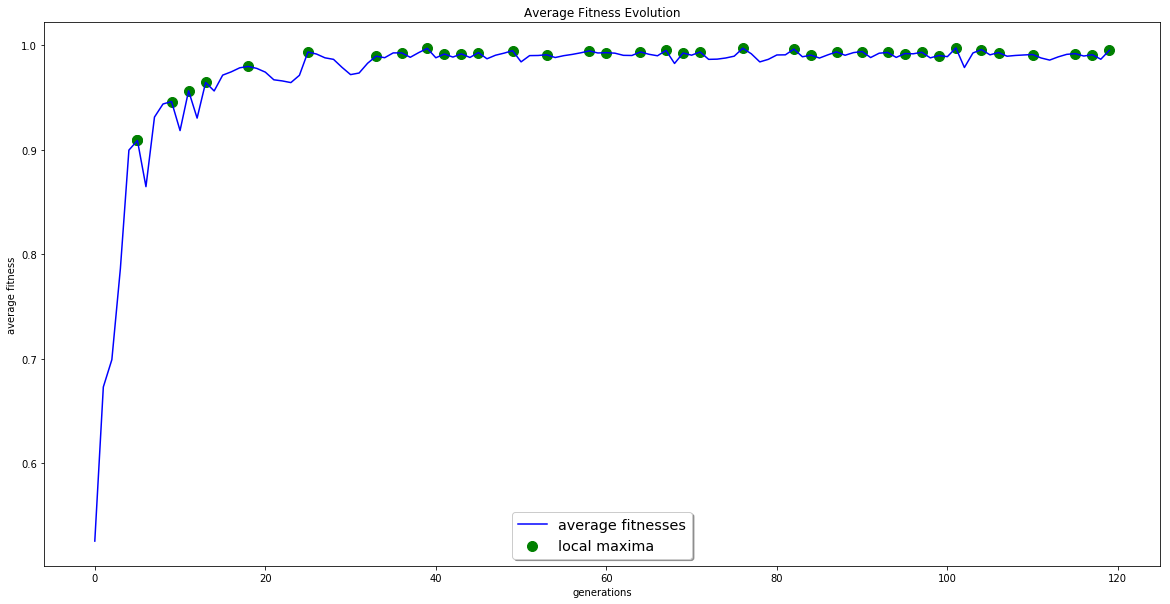

Best Average Fitness:  0.9974299999999999  In Generation:  101


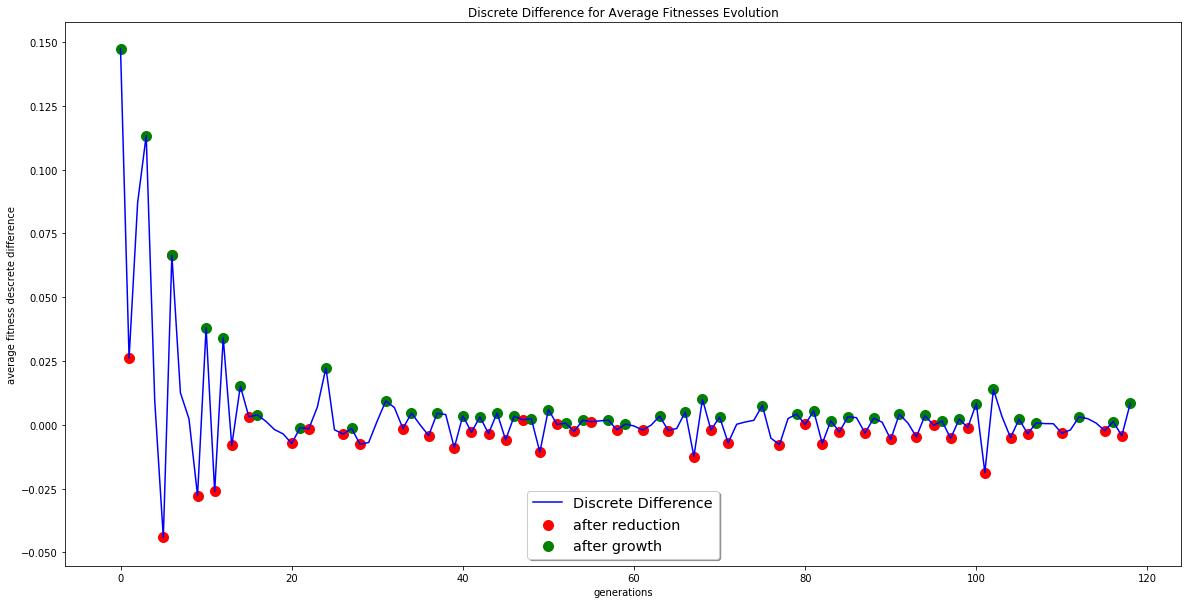

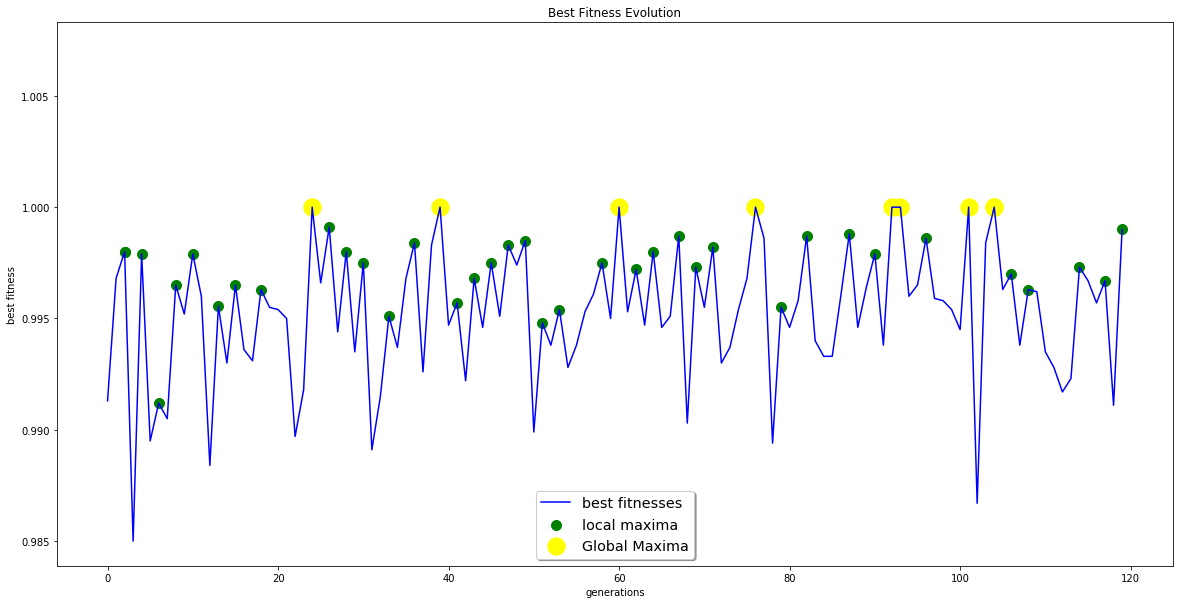

Generations with perfect fitness: 
- 24 ª geração
- 39 ª geração
- 60 ª geração
- 76 ª geração
- 92 ª geração
- 93 ª geração
- 101 ª geração
- 104 ª geração


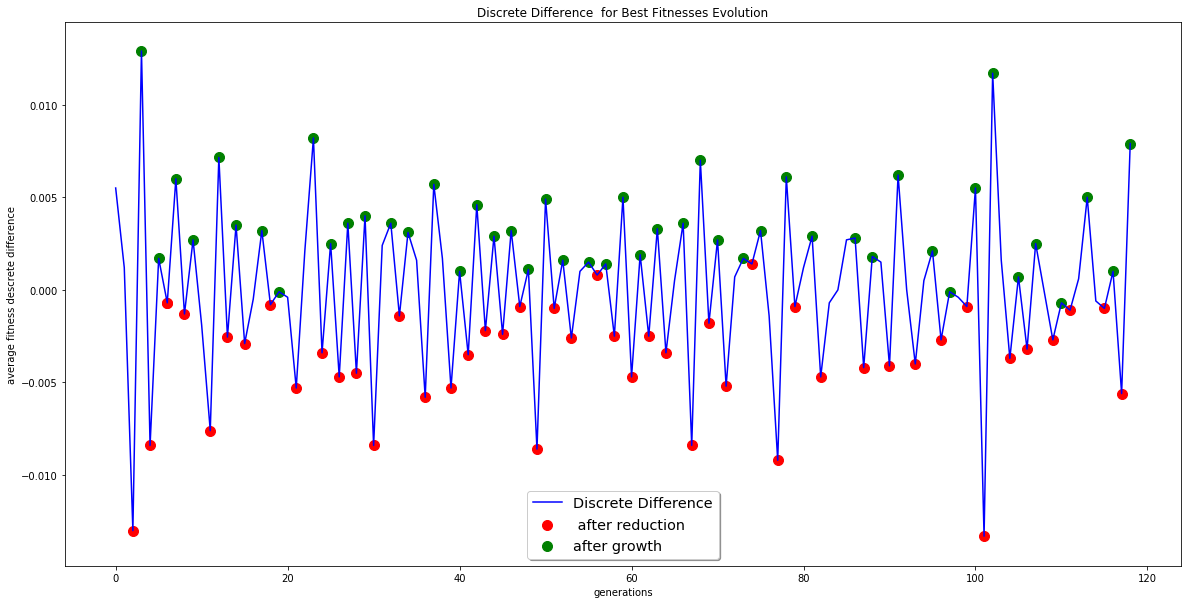

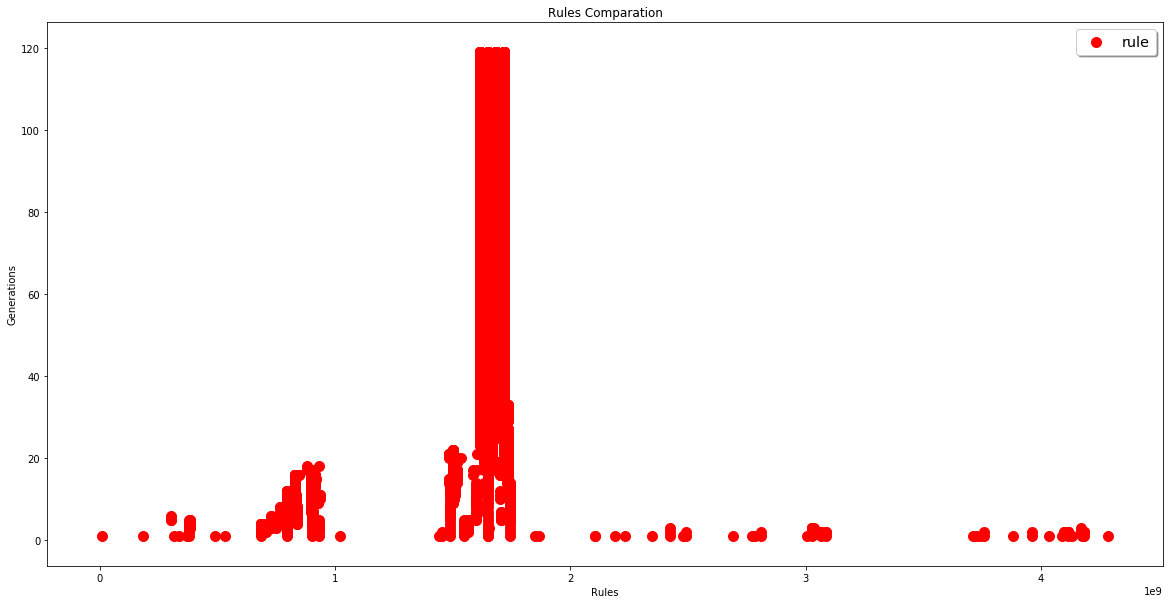

In [55]:
def main():
    matrix=[]
    with open('Regras.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            matrix.append(row)
    matrix.pop(0)
    average_plot(matrix)
    best_rules = best_fitnesses_plot(matrix)
    rule_comparator(matrix)
            
     
main()

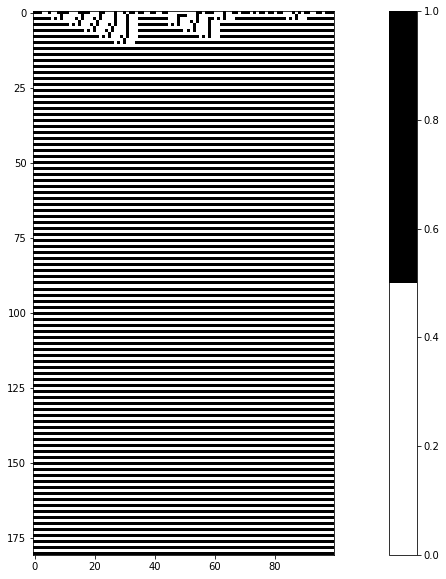

In [44]:
phi = '1010000011001110000011100000011'
phi = int(phi[::-1],2)
CA(phi, 3)

Exemplo de regra com fitness "perfeito".

### Análise de plots
<p><justify>Como abordava acima, para perceber melhor a evolução dos fitnesses, decidi guardar todas as gerações, o que me fez poder analisar a evolução de todas as regras.</justify></p>
<p><justify>Como podemos observar, a melhor regra andou sempre bem acima do fitness 0.9, algo que pode ter aontecido por mero acaso (no inicio) devido à randomização das regras. Isto não daria informação suficiente sobre a evolução dos fitnesses, portanto a análise das médias é necessária. De notar que o fitness se manteve durante perfeito durante duas gerações (entre a 92ª e 93ª).</justify></p>



<p><justify>Observando o gráfico de médias dos fitnesses, podemos perceber que as regras tiveram um crescimento bastante acentuado nas primeiras 5 gerações, chegando na 5ª a um valor acima dos 0.9.
Após a 5ª geração, observamos que os fitnesses tiveram um crescimento um pouco mais atenuado até à 25ª geração, onde vai ocorrer de seguida uma ligeira descida e depois se fixa perto de 1.</justify></p>



<p><justify>Também importante realçar o facto de devido à mutation rate, o algoritmo conseguir sair de várias local Maximas, o que permitiu chegar mais próximo de um fitness perfeito. Isto sucedeu na geração 24.</justify></p>



<p><justify>Analisando a Discrete Difference, percebmos melhor que no que toca à media dos fitnesses, a maior evolução deu-se no inicio das gerações, avançando depois para um valor de variação próximo de 0. Já para o melhor fitness da geração, conseguimos perceber que este variou bastante ao longo de todas as gerações, complicando assim a tarefa de retirar qualquer análise, à parte de se notar que a mutação entra em ação várias vezes.</justify></p>


<p><justify>Por fim, uma pequena análise às regras, onde observamos que na primeira geração, são bastante disperças, mas que ao longo das gerações, vão ficando cada vez mais aproximadas umas às outras.
A geração onde isto é mais evidente é a 22ª, onde todas as regras passam a estar todas identicas e assim, a partir daí, começa a haver uma reprodução de regras extremamente similares. Algo a fazer para tentar mudar isto seria aumentar a mutação e diminutir os pontos de crossover de 2 para 1, pois assim dois pais só gerariam 2 filhos, o que poderia ajudar na diversidade.</justify></p>

***

# Conclusão
  
  
<p><justify>Com este projeto e especialmente esta análise, consegui entender melhor o processo de evolução da genética. Foi bastante útil tambem para entender como podemos moldar a evolução de valores conforme o objetivo final.</justify></p>
<p><justify>Tivesse mais tempo para analisar os dados mais profundamente, iria analisar as diferenças entre as regras e correlar isso com a evolução dos fitnesses. Sobre isto, apenas tenho a dizer que na minha ótica, esta cadeira deveria ser anual e não semestral, pois muito mais poderia ser feito. Algo que irei fazer depois do fim desta cadeira, será reutilizar este projeto para analizar regras para k's superiores, de forma a arranjar padrões ternários, pois acho que pode ser interessante.</justify></p>

<p><justify>Dizer também que este foi o projeto que mais me interessou ao longo da Licenciatura de Engenharia Informática e que me deixou com a incógnita sobre se Data Science não será a área que realmente me interessa no futuro. Comecei o semestre com algumas dificuldades na cadeira mas tive um ponto de viragem quando em conversa com o professor na avaliação prática intermédia, percebi que podia ser bom nesta area, o que me fez trabalhar ainda mais para completar o projeto e para aprender ainda mais. Por isto e pelo que cresci como pessoa este semestre, deixo um profundo agradecimento ao professor Manuel Marques Pita, que como nenhum outro professor, me soube cativar.</justify></p>



***

<a id='Anexos'></a>
# Anexos

Deixo em anexo nos links abaixo: (1)o CSV com regras e fitnesses de todas as gerações e (2)um googleSheet com a importação do CSV.

[Ficheiro CSV com todas as regras de todas as gerações](https://drive.google.com/drive/folders/1BqWKO3zTRfLFDZ2UpPC-L-WKSs8dIjm0?usp=sharing)


[Todas as Regras num GoogleSheets](https://docs.google.com/spreadsheets/d/1btAM7EZcDlFoYeFj6CG_FKmDREA6BdrBt2lWYke087c/edit?usp=sharing)